In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import shutil
from os.path import join

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)

    
import _ressources.chain as chain
import _ressources.tools as tools
import _ressources.lumenclass as lc
import _ressources.gen_config as gc


from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm, SymLogNorm

main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/critical_chiv/'

theta = np.pi/3.
mu = np.sin(theta)**2 / (2*theta - np.sin(2*theta))


In [2]:
def logscale(decades, points, scale=10) :
    Lscale = []
    for d in decades :
        for p in points :
            Lscale += [p*scale**d]
    return Lscale

def read_eventfile(eventfile) :
    s = open(eventfile, 'r').readlines()
    if '(C)' in s[-1].split() :
        return ('C', int(s[-1].split()[-1]))
    elif '(D)' in s[-1].split() :
        return ('D', int(s[-1].split()[-1]))
    elif '(M)' in s[-1].split() :
        return ('M', int(s[-1].split()[-1]))
    
def read_configfile(config_folder, param) :

    lumens = np.loadtxt(join(config_folder, 'lumens.dat'))
    bridges = np.loadtxt(join(config_folder, 'bridges.dat'))

    if param == 'ca' :
        return lumens[1:-1, -1], bridges[1:-1, -1]
    elif param == 'length' :
        return lumens[1:-1, 2], bridges[1:-1, 3]
    elif param == 'nb_ions' :
        return lumens[1:-1, 3]
    return None

def give_outputs(chi_list, folder, param) :
    out_chi = {}
    for chi in chi_list :
        out_chi[chi] = {}
        L = os.listdir(join(folder, 'chiv' + str(chi)))
        for elem in L :
            #if elem.startswith('run') :
            if elem.startswith('run') :
                eventfile = join(folder, 'chiv' + str(chi), elem, 'events.txt')
                config_folder = join(folder, 'chiv' + str(chi), elem, 'config')
                try :
                    out_chi[chi][elem] = [read_configfile(config_folder, param), read_eventfile(eventfile)]
                except :
                    print(chi, elem)
    return out_chi

def plot_diagram(out, param_pos) :
    color_dict = {'M' : ['purple', 's'], 
                  'C' : {1 : ['blue', '*'], 2 : ['red', 'o']}, 
                  'D' : ['green', '^']}
    for chi in out.keys() :
        print(str(chi) + '      ', end='\r')
        for sim in out[chi].keys() :
            y = out[chi][sim][0][param_pos[0]][param_pos[1]]
            try :
                fate, winner = out[chi][sim][1]
            except :
                print(chi, sim, out[chi][sim][1])     
                fate = None
            
            if fate == 'C' :
                color, symbol = color_dict[fate][winner]
            elif fate != None :
                color, symbol = color_dict[fate]
            
            if out[chi][sim][1] != None and fate != None :
                plt.scatter(float(chi), y, color = color, marker=symbol)
            else :
                plt.scatter(float(chi), y, color = 'k', marker='*')

    
def edit_configtpl(main_dir, subdir, subsubdir, chiv,  chis) :
    f = open(join(main_dir, subdir, subsubdir, 'config.conf'), 'r')
    L = f.readlines()
    f.close()
    #print(L[1])
    #print(os.path.join(main_dir,subdir,subsubdir))
    L[11] = 'outdir = '+join(main_dir,subdir,subsubdir) + '\n'
    L[40] = L[40].replace('chis = 50.', 'chis = ' + chis)
    L[41] = L[41].replace('chiv = 50.', 'chiv = ' + chiv)
    s = ''
    for i in range(len(L)) :
        s += str(L[i])
    f = open(join(main_dir, subdir, subsubdir, 'config.conf'), 'w')
    f.write(s)
    f.close()
    
    

(0.1, 2.2)

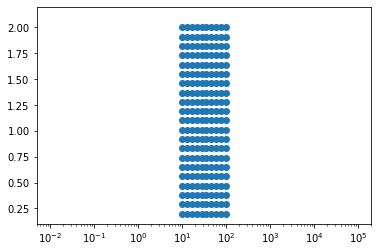

In [3]:
xmin, xmax = 10, 100.
ymin, ymax = 0.2, 2
x = np.logspace(np.log10(xmin), np.log10(xmax), 10)
#y = np.logspace(ymin, ymax, 25)
y = np.linspace(0.2, 2., 21)
xscatter, yscatter = np.meshgrid(x, y)

plt.xscale('log')
plt.scatter(xscatter, yscatter)

plt.ylim(ymin*.5, ymax*1.1)


In [4]:
new_dict = 0
clean_dir = 1

if new_dict :
    if clean_dir : 
        for elem in os.listdir(main_dir) :
            if elem.startswith('chis') : 
                shutil.rmtree(join(main_dir, elem))
    
    for i in range(len(x)) :
        chis = "{:.3e}".format(x[i])
        subdir = 'chis'+chis
        

        # Make directories
        try : 
            os.mkdir(join(main_dir, subdir))
            shutil.copy2(join(main_dir, 'config.conf.tpl'), join(main_dir, subdir, 'config.conf.tpl'))
        except : pass
        #shutil.copytree(join(main_dir, 'config'), join(main_dir, subdir, subsubdir, 'config'))

        for j in range(len(y)) :
            chiv = "{:.3e}".format(y[j])
            subsubdir = 'chiv'+chiv
            
            #if 1 :
            try : 
                os.mkdir(join(main_dir, subdir, subsubdir))
                shutil.copy2(join(main_dir, subdir, 'config.conf.tpl'), join(main_dir, subdir, subsubdir, 'config.conf'))
            #else :  1
            except : pass
            
            # Edit config.conf.tpl
            edit_configtpl(main_dir, subdir, subsubdir, chiv, chis)
            

        

        # Gen configurations
        #os.chdir(join(main_dir, subdir, subsubdir))
        #arg1 = 'params=paramsfile.txt'
        #gc.main(join(main_dir, subdir, subsubdir, 'config.conf.tpl'), args=['params=paramsfile.txt'])
        #os.chdir(cwd)

    s = 'chis = '
    for i in range(len(x)) :
        s += "{:.3e}".format(x[i]) +','
    print(s)
    
    r = 'chiv = '
    for j in range(len(y)) :
        r += "{:.3e}".format(y[j]) +','
    print(r)
    

In [5]:
def read_eventfile(eventfile) :
    s = open(eventfile, 'r').readlines()
    if '(C)' in s[-1].split() :
        return ('C', int(s[-1].split()[-1]))
    elif '(D)' in s[-1].split() :
        return ('D', int(s[-1].split()[-1]))
    elif '(M)' in s[-1].split() :
        return ('M', int(s[-1].split()[-1]))
    
def read_configfile(config_folder, param) :

    lumens = np.loadtxt(join(config_folder, 'lumens.dat'))
    bridges = np.loadtxt(join(config_folder, 'bridges.dat'))

    if param == 'ca' :
        return lumens[1:-1, -1], bridges[1:-1, -1]
    elif param == 'length' :
        return lumens[1:-1, 2], bridges[1:-1, 3]
    elif param == 'nb_ions' :
        return lumens[1:-1, 3]
    return None

def give_outputs(chis_list, chiv_list, folder) :
    out = {}
    for chis in chis_list :
        out[chis] = {}
        for chiv in chiv_list :
            eventfile = join(folder, 'chis' + str(chis), 'chiv' + str(chiv), 'events.txt')
            try :
            #if 1 :
                res = read_eventfile(eventfile)
                #print(res)
                out[chis][chiv] = res
            #else : 1
            except : pass
    return out

In [6]:
def plot_diagram(out) :

    color_dict = {'M' : ['purple', 's'], 
                  'C' : {1 : ['blue', '*'], 2 : ['red', 'o']}, 
                  'D' : ['green', '^']}
    for chis in out.keys() :
        print(str(chis) + '      ', end='\r')
        for chiv in out[chis].keys() :
            
            try :
                fate, winner = out[chis][chiv]
                #print(fate, winner)
            except :
                print(chis, chiv)     
                fate = None
            
            if fate == 'C' :
                color, symbol = color_dict[fate][winner]
            elif fate != None :
                color, symbol = color_dict[fate]
            
            if out[chis][chiv] != None and fate != None :
                plt.scatter(float(chis), float(chiv), color = color, marker=symbol)
            else :
                plt.scatter(float(chis), float(chiv), color = 'k', marker='*')

In [7]:
v2 = 0

In [8]:
if v2 : 
    chis_list = [elem[4:] for elem in os.listdir(join(main_dir, 'v2')) if elem.startswith('chis')]
    chiv_list = [elem[4:] for elem in os.listdir(join(main_dir, 'v2','chis'+chis_list[0])) if elem.startswith('chiv')]
else :
    chis_list = [elem[4:] for elem in os.listdir(join(main_dir)) if elem.startswith('chis')]
    chiv_list = [elem[4:] for elem in os.listdir(join(main_dir,'chis'+chis_list[0])) if elem.startswith('chiv')]




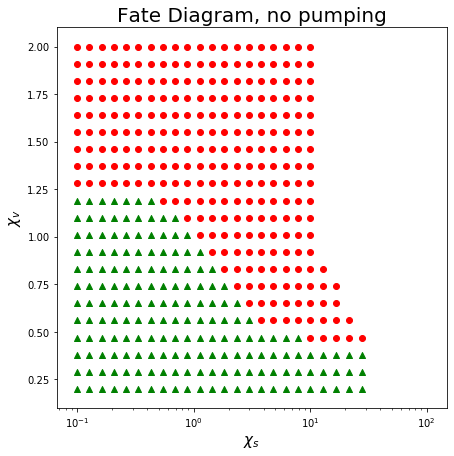

In [9]:
#chis_list = ["{:.3e}".format(x[i]) for i in range(len(x))]
#chiv_list = ["{:.3e}".format(y[j]) for j in range(len(y))]

if v2 : out = give_outputs(chis_list, chiv_list, os.path.join(main_dir, 'v2'))
else : out = give_outputs(chis_list, chiv_list, os.path.join(main_dir))

xmin, xmax = np.log10(np.min(np.array(chis_list, dtype=float))), np.log10(np.max(np.array(chis_list, dtype=float)))
ymin, ymax = np.log10(np.min(np.array(chiv_list, dtype=float))), np.log10(np.max(np.array(chiv_list, dtype=float)))

# ========================================

plt.figure(figsize=(7, 7))
plt.xscale('log')
#plt.yscale('log')

frac = 1.5
plt.xlim((1./frac)*10.**(xmin), frac*10.**(xmax))
plt.ylim(0.1, 2.1)
#plt.ylim()

plot_diagram(out)

plt.xlabel('$\chi_s$', fontsize=15)
plt.ylabel('$\chi_v$', fontsize=15)

plt.title('Fate Diagram, no pumping', fontsize=20)
#plt.savefig(join('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/','critical_chiv_vs_chis.eps'), format='eps')
plt.show()

In [10]:
np.sort(np.array(chis_list, dtype=float)), np.sort(np.array(chiv_list, dtype=float))

(array([  0.1   ,   0.1274,   0.1624,   0.2069,   0.2637,   0.336 ,
          0.4281,   0.5456,   0.6952,   0.8859,   1.129 ,   1.438 ,
          1.833 ,   2.336 ,   2.976 ,   3.793 ,   4.833 ,   6.158 ,
          7.848 ,  10.    ,  12.92  ,  16.68  ,  21.54  ,  27.83  ,
         35.94  ,  46.42  ,  59.95  ,  77.43  , 100.    ]),
 array([0.2 , 0.29, 0.38, 0.47, 0.56, 0.65, 0.74, 0.83, 0.92, 1.01, 1.1 ,
        1.19, 1.28, 1.37, 1.46, 1.55, 1.64, 1.73, 1.82, 1.91, 2.  ]))

Import config from /Users/mathieuleverge/git/chain_lumen/_data/critical_chiv/config/
Import successful !


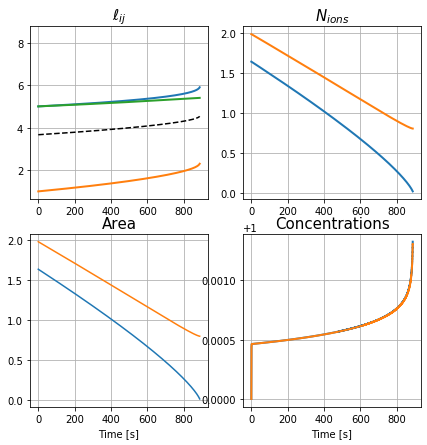

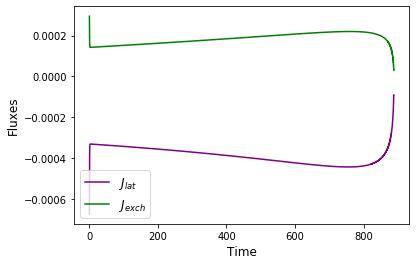

In [11]:
subdir = 'chis2.154e+01'
subsubdir = 'chiv3.800e-01'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, subsubdir, 'config.conf'))
#print(ch)
x_ch = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, subsubdir, 'sim_bridges.dat'))

x_log = 0
total_area = 0

#xmin, xmax = 827, 829

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, subsubdir, 'sim_all.dat'), hydroosmotic=True)
    #tools.plot_evolution(L, nions, ell, x_logscale=x_log, savename=join(main_dir, 'case2.eps'), savefig=False, nbins=5, show_totalarea=total_area, xlim=[xmin, xmax])
    tools.plot_evolution(L, nions, ell, x_logscale=x_log, savename=join(main_dir, 'case2.eps'), savefig=False, nbins=5, show_totalarea=total_area)

#print(read_eventfile(os.path.join(main_dir, subdir, subsubdir, 'events.txt')))
print('\n\n\n')

fluxes = np.loadtxt(os.path.join(main_dir, subdir, subsubdir, 'fluxes.dat'), skiprows=1)
end = 10
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(xmin, xmax)
plt.plot(fluxes[:-end, 0], fluxes[:-end, 1], label = r'$J_{lat}$', color = 'purple')
plt.plot(fluxes[:-end, 0], fluxes[:-end, 2], label = r'$J_{exch}$', color='green')

plt.legend(loc=3, fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Fluxes', fontsize=12)
plt.show()



In [3]:
def cnv(chiv, n) :
    return np.cosh(1./(n*chiv))

def snv(chiv, n) :
    return np.sinh(1./(n*chiv))

def cns(chis, n) :
    return np.cosh(1./(n*chis))

def sns(chis, n) :
    return np.sinh(1./(n*chis))

def Lambda(chis, chiv) :
    c1s, s1s = cns(chis, 1.), sns(chis, 1.)
    c1v, s1v = cnv(chiv, 1.), snv(chiv, 1.)
    c2s, s2s = cns(chis, 2.), sns(chis, 2.)
    c2v, s2v = cnv(chiv, 2.), snv(chiv, 2.)
    
    if chis == chiv :
        return np.cosh(0.5/chiv) * (1 - chiv*s1s) / (2*chiv*s1s) 
    return chis*(chis*s1s*c2v - chiv*(1.+c1s)*s2v) / (s1s * (chiv**2 - chis**2))

def J21v(dP1, dP2, dC1, dC2, ell, chiv, chis) :
    xiv = chiv*ell
    DP = dP2-dP1
    DC = dC2-dC1
    c2v = cnv(chiv, 2.)
    s2v = snv(chiv, 2.)
    return xiv*(DP*c2v + DC*Lambda(chis, chiv)/s2v)

def J21s(dC1, dC2, chis, ell) :
    xis = chis*ell
    DC = dC2-dC1
    c2s = cns(chis, 2.)
    s2s = sns(chis, 2.)
    return xis*DC*c2s/s2s
    

In [4]:
theta = np.pi/3.
nu = theta /np.sin(theta)
epsilon = 1e-3

Import successful !


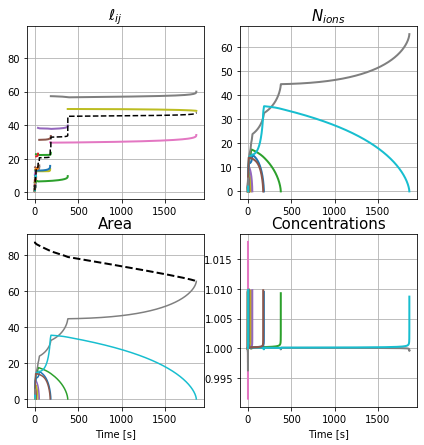

In [21]:
subdir = 'tests'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
#print(ch)
x_ch = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0
total_area = 1


if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    #tools.plot_evolution(L, nions, ell, x_logscale=x_log, savename=join(main_dir, 'case2.eps'), savefig=False, nbins=5, show_totalarea=total_area, xlim=[xmin, xmax])
    tools.plot_evolution(L, nions, ell, x_logscale=x_log, show_totalarea=total_area)


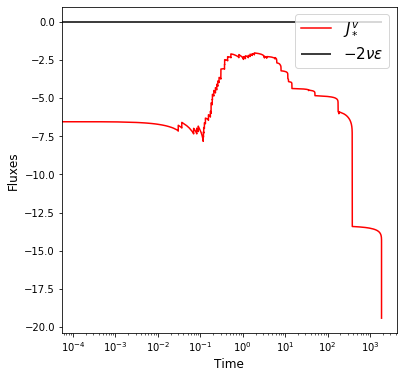

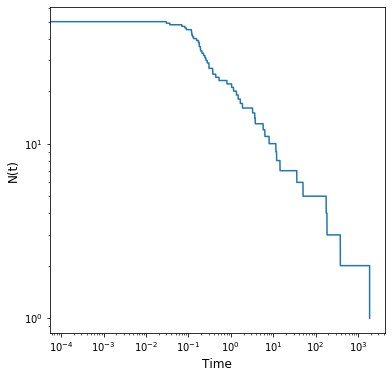

In [20]:
plt.figure(figsize=(6, 6))
fluxes=np.loadtxt(os.path.join(main_dir, 'tests', 'fluxes.dat'), skiprows=1)
plt.plot(fluxes[:, 0], fluxes[:, 1], label = r'$J^v_*$', color='r', zorder=0)
#plt.plot(fluxes[:, 0], fluxes[:, 2], label = r'$J^s_*$', color='b')
#plt.plot(fluxes[:, 0], fluxes[:, 3], label = r'$J_*$', color='g', linewidth=3)

plt.hlines(xmin=fluxes[0, 0], xmax=fluxes[-1, 0], y = -2*epsilon*nu, label = r'$-2\nu \epsilon$', zorder=2)
plt.legend(fontsize=15)
if x_log : plt.xscale('log')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Fluxes', fontsize=12)
#plt.vlines(x=1e1, ymin=-1e-2, ymax=1e-2)
#plt.vlines(x=1e2, ymin=-1e-2, ymax=1e-2)
#plt.ylim(-1e-1, 2.5e-2)
#plt.xlim(5e-2, 1.2*fluxes[-1, 0])
plt.show()

plt.figure(figsize=(6, 6))
Nt = np.loadtxt(os.path.join(main_dir, 'tests', 'sim_nlum.dat'))
plt.xscale('log')
plt.yscale('log')
plt.plot(Nt[:, 0], Nt[:,1])
k, a = 50., -2./5
t = np.logspace(0, 3)
#plt.vlines(x=1e1, ymin=1., ymax=1e2)
#plt.vlines(x=1e2, ymin=1., ymax=1e2)
#plt.plot(t, k*t**a)
plt.xlabel('Time', fontsize=12)
plt.ylabel('N(t)', fontsize=12)
plt.show()

In [4]:
def Z(Xs, Xv) :
    if Xv != Xs :
        th = (1+np.tanh(0.5/Xv))
        prefactor = (Xv*Xs)*(Xv**2 - Xs**2)
        last = 0.5*( (Xv+Xs)*np.cosh(0.5/Xv - 1./Xs) + (Xv-Xs)*np.cosh(0.5/Xv + 1./Xs) ) - Xv*np.cosh(0.5/Xv)
        return th*prefactor*last
    else :
        return 1.
